In [9]:
import numpy as np
import h5py 
import pycap
from pandas import DataFrame

In [10]:
# define dictionaries we'll use later
sys_dict = {"geometry":    '''N  0  0   1.039
                             N  0  0   -1.039
                            Gh 0  0   0.0''',
            "basis_file":"test_bas.bas",
            "bohr_coordinates": "true",
            "cart_bf": ""}
cap_dict = {
            "cap_type": "box",
            "cap_x":"2.76",
            "cap_y":"2.76",
            "cap_z":"4.88",
            "Radial_precision": "14",
            "angular_points": "110"
}

In [11]:
# read in electronic structure data
es_dict = {"method" : "ms-caspt2",
           "molcas_output":"anion_reference.out",
           "rassi_h5":"test.rassi.h5",
}
s = pycap.System(sys_dict)
pc = pycap.Projected_CAP(s,cap_dict,10,"openmolcas")
pc.read_data(es_dict)

Successfully read in zeroth order Hamiltonian from file:anion_reference.out
Successfully read in densities from file:test.rassi.h5


In [12]:
# do cap calculation, print matrices
pc.compute_ao_cap()
pc.compute_projected_cap()
mat=pc.get_projected_cap()
h0 = pc.get_H()
print("Zeroth order Hamiltonian")
print(DataFrame(h0).to_string(index=False, header=False))
print("CAP matrix")
print(DataFrame(mat).to_string(index=False, header=False))

Calculating CAP matrix in AO basis...
Integration time:3.254084
Zeroth order Hamiltonian
-109.305208   -0.000000    0.000034    0.002097   -0.003538   -0.000063   -0.000090   -0.002080   -0.000000    0.000000
  -0.000000 -109.305208   -0.002097    0.000034   -0.000063    0.003538   -0.002080    0.000090   -0.000000    0.000000
   0.000034   -0.002097 -109.240716   -0.000000   -0.000050    0.027058   -0.019596    0.001166   -0.000000   -0.000000
   0.002097    0.000034   -0.000000 -109.240716    0.027058    0.000050    0.001166    0.019596   -0.000000   -0.000000
  -0.003538   -0.000063   -0.000050    0.027058 -109.217809    0.000000   -0.002954   -0.048141    0.000000    0.000000
  -0.000063    0.003538    0.027058    0.000050    0.000000 -109.217809    0.048141   -0.002954   -0.000000    0.000000
  -0.000090   -0.002080   -0.019596    0.001166   -0.002954    0.048141 -109.072142    0.000000    0.000000   -0.000000
  -0.002080    0.000090    0.001166    0.019596   -0.048141   -0.002954

In [13]:
# pass densities as numpy arrays
# set up stuff for hdf5
f = h5py.File('test.rassi.h5', 'r')
arr = f["SFS_TRANSITION_DENSITIES"]
pc = pycap.Projected_CAP(s,cap_dict,10,"openmolcas")
for i in range(0,10):
    for j in range(i,10):
        arr1 = np.reshape(arr[i][j],(119,119))
        pc.add_tdm(arr1,i,j)
        if i!=j:
            pc.add_tdm(arr1,j,i)
pc.compute_ao_cap()
pc.compute_projected_cap()
mat=pc.get_projected_cap()
print(DataFrame(mat).to_string(index=False, header=False))

Calculating CAP matrix in AO basis...
Integration time:3.152447
-4.480785e+01  4.763634e-12 -3.508359e-01 -2.187164e+01 -1.011089e+01 -1.808094e-01  2.140307e-01  4.927576e+00 -4.382804e-11  1.782803e-10
 4.763634e-12 -4.480785e+01  2.187164e+01 -3.508359e-01 -1.808094e-01  1.011089e+01  4.927576e+00 -2.140307e-01  1.811065e-10  4.356842e-11
-3.508359e-01  2.187164e+01 -2.246989e+01 -1.835421e-12  2.858387e-02 -1.552258e+01 -1.019857e+01  6.069928e-01 -3.122858e-10 -7.649703e-11
-2.187164e+01 -3.508359e-01 -1.835421e-12 -2.246989e+01 -1.552258e+01 -2.858387e-02  6.069928e-01  1.019857e+01 -7.682245e-11  3.356798e-10
-1.011089e+01 -1.808094e-01  2.858387e-02 -1.552258e+01 -1.407956e+01  1.702327e-11  7.152816e-01  1.165607e+01 -1.184679e-10  5.248892e-10
-1.808094e-01  1.011089e+01 -1.552258e+01 -2.858387e-02  1.702327e-11 -1.407956e+01 -1.165607e+01  7.152816e-01 -6.277020e-10 -1.298809e-10
 2.140307e-01  4.927576e+00 -1.019857e+01  6.069928e-01  7.152816e-01 -1.165607e+01 -1.154507e+0

In [ ]:
pc.get_ao_cap()

In [ ]:
s.get_overlap_mat()

In [14]:
import os
import functools
from numpy import linalg as LA
import matplotlib.pyplot as plt
caspt2_energy = -109.35042571
E_0 = caspt2_energy
au2eV= 27.2113961
@functools.total_ordering
class root():
    def __init__(self, energy, eta):
        self.eta = eta
        self.energy = energy
    
    def __lt__(self, other):
        return self.eta < other.eta
    
    def __eq__(self, other):
        return self.eta == other.eta and self.eta == other.eta

class trajectory():
    def __init__(self,states,guess):
        min=500
        cur=-1
        for st in states:
            if np.absolute(st.energy-guess)<min:
                cur=st
                min=np.absolute(st.energy-guess)
        self.last=cur
        self.states=[cur]
    
    def add_state(self,states):
        min=500
        cur=-1
        for st in states:
            if np.absolute(st.energy-guess)<min:
                cur=st
                min=np.absolute(st.energy-self.last.energy)
        self.states.append(cur)
    
    def get_corrections(self):
        energies=[]
        etas=[]
        for st in self.states:
            energies.append(st.energy)
            etas.append(st.eta)
        derivs=list(np.gradient(energies)/np.gradient(etas))
        for i in range(0,len(self.states)):
            self.states[i].corr_energy=self.states[i].energy-derivs[i]*self.states[i].eta

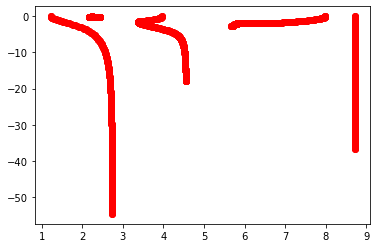

In [15]:
H_0 = h0
cap_mat = mat
guess=3
eta_list = np.linspace(0,3000,301)
eta_list = eta_list * 1E-5
all_roots=[]
for i in range(0,len(eta_list)):
    eta=eta_list[i]
    roots=[]
    fullH = H_0 +1.0j * eta * cap_mat
    eigv,eigvc=LA.eig(fullH)
    for eig in eigv:
        E = (eig - E_0) * au2eV
        roots.append(root(E,eta))
        all_roots.append(root(E,eta))
    if i==0:
        traj=trajectory(roots,guess)
    else:
        traj.add_state(roots)
re_traj = []
im_traj = []
energies=[]
for root in all_roots:
    re_traj.append(np.real(root.energy))
    im_traj.append(np.imag(root.energy))
    energies.append(root.energy)
plt.plot(re_traj,im_traj,'ro')
plt.show()

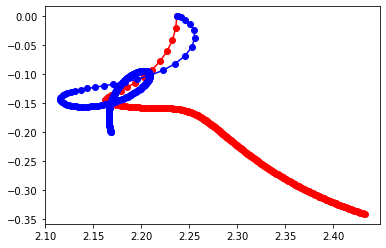

In [16]:
#plot trajectories of interest
traj.get_corrections()
re_traj = []
im_traj = []
corr_re=[]
corr_im=[]
uc_energies=[]
corr_energies=[]
for root in traj.states:
    uc_energies.append(root.energy)
    re_traj.append(np.real(root.energy))
    im_traj.append(np.imag(root.energy))
    corr_re.append(np.real(root.corr_energy))
    corr_im.append(np.imag(root.corr_energy))
    corr_energies.append(root.corr_energy)
plt.plot(re_traj,im_traj,'-ro')
plt.plot(corr_re,corr_im,'-bo')
plt.show()

In [ ]:
# Future
from pyscf import gto, scf, ci, ao2mo
ghost_bas = gto.basis.load('/Users/JG/Documents/Software/OpenCAP/opencap/example/pyscf_bas.bas', 'H')
N_bas= gto.basis.load('/Users/JG/Documents/Software/OpenCAP/opencap/example/pyscf_bas.bas', 'N')
mol = gto.M(
            atom = 'N 0 0 0.55; N 0 0 -0.55',
            basis = {'N': N_bas, 'ghost': ghost_bas}
            )
mf = scf.RHF(mol).run()
myci = ci.CISD(mf).run()
myci.nroots = 6
myci.kernel()
# can get TDMs in AO basis for any pair of states
t_dm1 = myci.trans_rdm1(myci.ci[3], myci.ci[0])
t_dm1 = numpy.einsum('pi,ij,qj->pq', mf.mo_coeff, t_dm1, mf.mo_coeff.conj())